## Import Libraries

In [1]:
### Import Packages ###
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from scipy.fftpack import fft
from datetime import datetime, timedelta

#Jlab Packages
from data_utils import get_traces
from beam_settings_parser_hdf5 import BeamConfigParserHDF5
from beam_settings_prep import BeamConfigPreProcessor


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### BPM Config ###

In [2]:
class BPMDataConfig:

    def __init__(self):
        self.beam_settings_data_path = "/work/data_science/suf_sns/beam_configurations_data/processed_data/clean_beam_config_processed_df.csv"
        self.beam_param_parser_cfg = {"data_location": "/work/data_science/suf_sns/beam_configurations_data/hdf5_sept2024/"}
        self.beam_settings_prep_cfg = {
            "rescale": False,
            "beam_config": [
                'FE_IS:Match:TunerPos',
                'LEBT:Chop_N:V_Set',
                'LEBT:Chop_P:V_Set',
                'LEBT:Focus_1:V_Set',
                'LEBT:Focus_2:V_Set',
                'LEBT:Steer_A:V_Set',
                'LEBT:Steer_B:V_Set',
                'LEBT:Steer_C:V_Set',
                'LEBT:Steer_D:V_Set',
                'Src:Accel:V_Set',
                'Src:H2:Flw_Set',
                'Src:Ign:Pwr_Set',
                'Src:RF_Gnd:Pwr_Set',
                'ICS_Chop:RampDown:PW',
                'ICS_Chop:RampUp:PWChange',
                'ICS_MPS:Gate_Source:Offset',
                'ICS_Tim:Chop_Flavor1:BeamOn',
                'ICS_Tim:Chop_Flavor1:OnPulseWidth',
                'ICS_Tim:Chop_Flavor1:RampUp',
                'ICS_Tim:Chop_Flavor1:StartPulseWidth',
                'ICS_Tim:Gate_BeamRef:GateWidth',
                'ICS_Tim:Gate_BeamOn:RR'
            ]
        }
        self.beam_config = [
            'timestamps',
            'FE_IS:Match:TunerPos',
            'LEBT:Chop_N:V_Set',
            'LEBT:Chop_P:V_Set',
            'LEBT:Focus_1:V_Set',
            'LEBT:Focus_2:V_Set',
            'LEBT:Steer_A:V_Set',
            'LEBT:Steer_B:V_Set',
            'LEBT:Steer_C:V_Set',
            'LEBT:Steer_D:V_Set',
            'Src:Accel:V_Set',
            'Src:H2:Flw_Set',
            'Src:Ign:Pwr_Set',
            'Src:RF_Gnd:Pwr_Set',
            'ICS_Chop:RampDown:PW',
            'ICS_Chop:RampUp:PWChange',
            'ICS_MPS:Gate_Source:Offset',
            'ICS_Tim:Chop_Flavor1:BeamOn',
            'ICS_Tim:Chop_Flavor1:OnPulseWidth',
            'ICS_Tim:Chop_Flavor1:RampUp',
            'ICS_Tim:Chop_Flavor1:StartPulseWidth',
            'ICS_Tim:Gate_BeamRef:GateWidth',
            'ICS_Tim:Gate_BeamOn:RR'
        ]

        self.column_to_add = [
    'FE_IS:Match:TunerPos',
    'LEBT:Chop_N:V_Set',
    'LEBT:Chop_P:V_Set',
    'LEBT:Focus_1:V_Set',
    'LEBT:Focus_2:V_Set',
    'LEBT:Steer_A:V_Set',
    'LEBT:Steer_B:V_Set',
    'LEBT:Steer_C:V_Set',
    'LEBT:Steer_D:V_Set',
    'Src:Accel:V_Set',
    'Src:H2:Flw_Set',
    'Src:Ign:Pwr_Set',
    'Src:RF_Gnd:Pwr_Set',
    'ICS_Tim:Gate_BeamOn:RR',
    'ICS_Chop-RampDown-PW',
    'ICS_Chop-RampUp-PWChange',
    'ICS_Tim-Gate_BeamRef-GateWidth'
]

        self.rename_mappings = {
    'ICS_Chop-RampDown-PW': 'ICS_Chop:RampDown:PW',
    'ICS_Chop-RampUp-PWChange': 'ICS_Chop:RampUp:PWChange',
    'ICS_MPS-Gate_Source-Offset': 'ICS_MPS:Gate_Source:Offset',
    'ICS_Chop-BeamOn-Width': 'ICS_Tim:Chop_Flavor1:BeamOn',
    'ICS_Chop-BeamOn-PW': 'ICS_Tim:Chop_Flavor1:OnPulseWidth',
    'ICS_Chop-RampUp-Width': 'ICS_Tim:Chop_Flavor1:RampUp',
    'ICS_Chop-RampUp-PW': 'ICS_Tim:Chop_Flavor1:StartPulseWidth',
    'ICS_Tim-Gate_BeamRef-GateWidth': 'ICS_Tim:Gate_BeamRef:GateWidth'
}


    def configs_hist(self, dataframe, timestamp):
        subset_columns = dataframe.columns.tolist()
        subset_columns.remove(timestamp)
        df_shifted = dataframe[subset_columns].shift(1)
        mask = (dataframe[subset_columns] == df_shifted).all(axis=1)
        dataframe = dataframe[~mask]

        dataframe['time_diff'] = dataframe[timestamp].diff()
        dataframe['timestamps_trm'] = dataframe[timestamp] + dataframe['time_diff'].shift(-1) - timedelta(seconds=0.000001)

        subset_columns.insert(0, timestamp)
        subset_columns.insert(1, "timestamps_trm")

        return dataframe[subset_columns]

    def summary(self, text, df):
        print(f'{text} shape: {df.shape}')

        # Filter for numeric columns only
        numeric_cols = df.select_dtypes(include=['number'])

        summ = pd.DataFrame(numeric_cols.dtypes, columns=['dtypes'])
        summ['null'] = numeric_cols.isnull().sum()
        summ['unique'] = numeric_cols.nunique()
        summ['min'] = numeric_cols.min()
        summ['median'] = numeric_cols.median()
        summ['max'] = numeric_cols.max()
        summ['mean'] = numeric_cols.mean()
        summ['std'] = numeric_cols.std()
        summ['duplicate'] = df.duplicated().sum()

        return summ


    def update_beam_config(self,beam_config_df):
        for col in self.column_to_add:
            if col not in beam_config_df.columns:
                beam_config_df[col] = np.nan

        beam_config_df.rename(columns=self.rename_mappings, inplace=True)
        return beam_config_df


# Create an instance of BPMDataConfig
dc = BPMDataConfig()


In [3]:
beam_config_df = pd.read_csv(dc.beam_settings_data_path)
beam_config_df = beam_config_df.drop("Unnamed: 0", axis=1, errors='ignore')
beam_config_df['timestamps'] = pd.to_datetime(beam_config_df['timestamps'])


In [4]:
### Sep24 hdf5 beam settings ###
parser = BeamConfigParserHDF5(dc.beam_param_parser_cfg)
data, _ = parser.run()

Provided file is not hdf5 format, skipping:  .ipynb_checkpoints
BeamParamParser: Number of samples parsed
FE_IS:Match:TunerPos 633
ICS_Chop:RampDown:PW 41
ICS_Chop:RampUp:PWChange 869
ICS_MPS:Gate_Source:Offset 262
ICS_Tim:Chop_Flavor1:BeamOn 1780
ICS_Tim:Chop_Flavor1:OnPulseWidth 2564
ICS_Tim:Chop_Flavor1:RampUp 52
ICS_Tim:Chop_Flavor1:StartPulseWidth 16
ICS_Tim:Gate_BeamOn:RR 12437
ICS_Tim:Gate_BeamRef:GateWidth 1818
LEBT:Chop_N:V_Set 6557
LEBT:Chop_P:V_Set 6561
LEBT:Focus_1:V_Set 3018
LEBT:Focus_2:V_Set 3018
LEBT:Steer_A:V_Set 6550
LEBT:Steer_B:V_Set 6557
LEBT:Steer_C:V_Set 6554
LEBT:Steer_D:V_Set 6551
Src:Accel:V_Set 3408
Src:H2:Flw_Set 2959
Src:Ign:Pwr_Set 2942
Src:RF_Gnd:Pwr_Set 5


In [5]:
### Get Prepared datasets ###
prep = BeamConfigPreProcessor(dc.beam_settings_prep_cfg)
prepared_settings, run_cfg = prep.run(data)


['FE_IS:Match:TunerPos', 'LEBT:Chop_N:V_Set', 'LEBT:Chop_P:V_Set', 'LEBT:Focus_1:V_Set', 'LEBT:Focus_2:V_Set', 'LEBT:Steer_A:V_Set', 'LEBT:Steer_B:V_Set', 'LEBT:Steer_C:V_Set', 'LEBT:Steer_D:V_Set', 'Src:Accel:V_Set', 'Src:H2:Flw_Set', 'Src:Ign:Pwr_Set', 'Src:RF_Gnd:Pwr_Set', 'ICS_Chop:RampDown:PW', 'ICS_Chop:RampUp:PWChange', 'ICS_MPS:Gate_Source:Offset', 'ICS_Tim:Chop_Flavor1:BeamOn', 'ICS_Tim:Chop_Flavor1:OnPulseWidth', 'ICS_Tim:Chop_Flavor1:RampUp', 'ICS_Tim:Chop_Flavor1:StartPulseWidth', 'ICS_Tim:Gate_BeamRef:GateWidth', 'ICS_Tim:Gate_BeamOn:RR']
Length of beam param df:  48909


In [6]:
# Convert configs to list
beam_config_df = dc.update_beam_config(beam_config_df)
bpm = pd.concat([beam_config_df, prepared_settings])

In [7]:
dc.summary('bpm_summary', bpm)

bpm_summary shape: (67764, 23)


,dtypes,null,unique,min,median,max,mean,std,duplicate
ICS_Tim:Chop_Flavor1:BeamOn,float64,0,645,0.000000,886.000000,1000.000000,794.016616,256.706192,827
ICS_Tim:Chop_Flavor1:StartPulseWidth,float64,0,36,0.000000,18.000000,55.000000,18.404389,3.075782,827
ICS_Chop:RampUp:PWChange,float64,0,27,0.000000,4.000000,4095.000000,10.059028,97.181057,827
ICS_Chop:RampDown:PW,float64,0,16,0.000000,18.000000,45.000000,18.192654,1.649764,827
ICS_MPS:Gate_Source:Offset,float64,0,140,-949.967480,-20.000000,0.000000,-30.240840,77.447447,827
ICS_Tim:Chop_Flavor1:RampUp,float64,0,49,0.000000,98.000000,99.000000,90.025781,26.656475,827
ICS_Tim:Chop_Flavor1:OnPulseWidth,float64,0,39,0.000000,40.000000,55.000000,33.201124,11.371221,827
ICS_Tim:Gate_BeamRef:GateWidth,float64,0,664,0.000000,986.000000,1052.000000,825.438979,343.844063,827
FE_IS:Match:TunerPos,float32,18855,3,58.009998,58.040001,58.040001,58.035648,0.020661,827
LEBT:Chop_N:V_Set,float32,18855,2,2.430000,2.700000,2.700000,2.699995,0.001783,827


### DCM Configs

In [8]:
class DCMDatConfig:

    def __init__(self):
        self.dataset1_loc = "/work/data_science/suf_sns/DCM_Errant/"
        self.dataset2_loc = "/w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024"
        self.start_date = 20220218
        self.end_date = 20220318
        self.anomaly_type = "00110000"  # --  48
        self.length_of_waveform = 10000
        self.exclude_dates = [20220220, 20220221, 20220222, 20220223, 20220301, 20220308, 20220309, 20220315]  # Fixed date

        self.filtered_normal_files = []
        self.filtered_anomaly_files = []
        self.filtered_normal_files2 = []
        self.filtered_anomaly_files2 = []
        self.traces = []
        self.timestamps = []
        

    
    def GetSepFilteredFiles(self):
        subfolders = [f.path for f in os.scandir(self.dataset2_loc) if f.is_dir()]
        for directory in subfolders:
            if "normal" in directory or "anomal" in directory:
                for root, _, files in os.walk(directory):
                    for file in files:
                        if ".gz" in file:
                            if 'normal' in directory:
                                self.filtered_normal_files2.append(os.path.join(root, file))
                            elif "anomal" in directory:
                                self.filtered_anomaly_files2.append(os.path.join(root, file))

        print('Number of available normal files:', len(self.filtered_normal_files2))
        print('Number of available anomaly files:', len(self.filtered_anomaly_files2))
        return self.filtered_normal_files2, self.filtered_anomaly_files2

    def GetTracesAndTs(self,filtered_files):
        index = np.random.randint(0, len(filtered_files))
        filepath = filtered_files[index]
        print(index)
        try:
            self.traces, self.timestamps = get_traces(filepath, var_id="Trace2", begin=3000, shift=self.length_of_waveform, data_type=0)
        except Exception as e:
            print("Error in reading the file: ", filepath)
            print("Error:", e)
        return self.traces, self.timestamps
        

dcm = DCMDatConfig()


In [9]:
### Print Sep Data Details ###
filtered_normal_files_sep,filtered_anomaly_files_sep=dcm.GetSepFilteredFiles()

Number of available normal files: 10699
Number of available anomaly files: 20592


## Get Traces and Timestamps 

In [10]:
traces_norm,timestamps_norm=dcm.GetTracesAndTs(filtered_normal_files_sep)

5777


In [11]:
traces_anorm,timestamps_anorm=dcm.GetTracesAndTs(filtered_anomaly_files_sep)

7153


## Merge Datasets

In [12]:
class MergeDatasets:
    
    def __init__(self):
        self.length_of_waveform = 10000
    
    def process_files(self,file_list, label, flag_value, data_type, alarm=None):
        traces, timestamps, flag, file = [], [], [], []

        for dcml in file_list[:20]:
            if alarm is not None:
                tmp_trace, tmp_timestamp = get_traces(
                dcml, var_id="Trace2", begin=3000, shift=self.length_of_waveform, data_type=data_type, alarm=alarm
            )
            else:
                tmp_trace, tmp_timestamp = get_traces(
                dcml, var_id="Trace1", begin=3000, shift=self.length_of_waveform, data_type=data_type
            )

            if not tmp_trace or not tmp_timestamp:
                print(f"Skipping {dcml} due to empty trace/timestamp")
                continue

            tmp_trace = np.array(tmp_trace)
            tmp_timestamp = np.array(tmp_timestamp)

            if len(tmp_trace) > 1:
                tmp_trace = tmp_trace[1:]
            if len(tmp_timestamp) > 1:
                tmp_timestamp = tmp_timestamp[1:]

            traces.extend(tmp_trace.tolist())
            flag.extend([flag_value] * len(tmp_trace))
            file.extend([label] * len(tmp_trace))
            timestamps.extend(tmp_timestamp.tolist())

        return pd.DataFrame({
        'anomoly_flag': flag,
        'file': file,
        'timestamps': timestamps,
        'traces': traces
    })


md = MergeDatasets()

In [13]:
# Process all datasets
dcm_Sep24_N = md.process_files(file_list=filtered_normal_files_sep, label='Sep24', flag_value=0, data_type=0)

In [14]:
dcm_Sep24_A = md.process_files(file_list=filtered_anomaly_files_sep,label="Sep24", flag_value=1, data_type=-1,alarm=48)

File:  /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/03_18/20240903_183444.5928_DCML.bin.gz   bWidth below threshold: 52
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/03_18/20240903_183444.5928_DCML.bin.gz due to empty trace/timestamp


/scratch/slurm/42225289/.cache/tmp/ipykernel_2118409/2665616354.py:19: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not tmp_trace or not tmp_timestamp:


Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/03_18/20240903_185817.2886_DCML.bin.gz due to empty trace/timestamp
File:  /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/03_18/20240903_182423.6166_DCML.bin.gz   bWidth below threshold: 30
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/03_18/20240903_182423.6166_DCML.bin.gz due to empty trace/timestamp
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/01_15/20240901_153409.4191_DCML.bin.gz due to empty trace/timestamp
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/01_15/20240901_151450.1136_DCML.bin.gz due to empty trace/timestamp
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/01_15/20240901_152410.2755_DCML.bin.gz due to empty trace/timestamp
Skipping /w/data_science-sciwork24/suf_sns/DCML_dataset_Sept2024/anomalies/01_15/20240901_153652.7629_DCML.bin.gz due to empty trace/timestamp
S

In [15]:
# Combine all into one DataFrame
dcm=pd.concat([dcm_Sep24_N, dcm_Sep24_A], ignore_index=True)

In [16]:
merged_df = pd.merge_asof(
    dcm.sort_values("timestamps"), 
    bpm.sort_values("timestamps"), 
    on="timestamps", 
    direction="nearest"
)
merged_df.columns

Index(['anomoly_flag', 'file', 'timestamps', 'traces',
       'ICS_Tim:Chop_Flavor1:BeamOn', 'ICS_Tim:Chop_Flavor1:StartPulseWidth',
       'ICS_Chop:RampUp:PWChange', 'ICS_Chop:RampDown:PW',
       'ICS_MPS:Gate_Source:Offset', 'ICS_Tim:Chop_Flavor1:RampUp',
       'ICS_Tim:Chop_Flavor1:OnPulseWidth', 'ICS_Tim:Gate_BeamRef:GateWidth',
       'FE_IS:Match:TunerPos', 'LEBT:Chop_N:V_Set', 'LEBT:Chop_P:V_Set',
       'LEBT:Focus_1:V_Set', 'LEBT:Focus_2:V_Set', 'LEBT:Steer_A:V_Set',
       'LEBT:Steer_B:V_Set', 'LEBT:Steer_C:V_Set', 'LEBT:Steer_D:V_Set',
       'Src:Accel:V_Set', 'Src:H2:Flw_Set', 'Src:Ign:Pwr_Set',
       'Src:RF_Gnd:Pwr_Set', 'ICS_Tim:Gate_BeamOn:RR'],
      dtype='object')

In [17]:
merged_df.head()

,anomoly_flag,file,timestamps,traces,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,...,LEBT:Focus_2:V_Set,LEBT:Steer_A:V_Set,LEBT:Steer_B:V_Set,LEBT:Steer_C:V_Set,LEBT:Steer_D:V_Set,Src:Accel:V_Set,Src:H2:Flw_Set,Src:Ign:Pwr_Set,Src:RF_Gnd:Pwr_Set,ICS_Tim:Gate_BeamOn:RR
0,1,Sep24,2024-09-01 15:05:05.036102,"[-0.000244140625, -0.0005371093866415322, -0.0...",908.0,18.0,3.0,18.0,-24.0,98.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
1,1,Sep24,2024-09-01 15:14:51.180287,"[-0.0005859375232830644, -0.000390625005820766...",908.0,18.0,3.0,18.0,-24.0,98.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
2,1,Sep24,2024-09-01 15:23:58.859281,"[9.765625145519152e-05, -0.0002929687616415322...",908.0,18.0,3.0,18.0,-24.0,98.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
3,1,Sep24,2024-09-01 15:31:43.174806,"[0.0003906250058207661, 0.0002929687616415322,...",908.0,18.0,3.0,18.0,-24.0,98.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
4,1,Sep24,2024-09-01 15:37:38.527843,"[-0.0003417968691792339, 0.0005859375232830644...",908.0,18.0,3.0,18.0,-24.0,98.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002


## Data Preprocessing

In [18]:
class DataPreprocessor:
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def check_nan(self):
        nan_counts = self.df.isna().sum()
        return nan_counts[nan_counts > 0]

    def remove_nan(self):
        self.df.dropna(inplace=True)
        return self.df

    def check_duplicates(self):
        df_copy = self.df.applymap(lambda x: tuple(x) if isinstance(x, np.ndarray) else x)
        return df_copy.duplicated().sum()


    def remove_duplicates(self):
        self.df.drop_duplicates(inplace=True)
        return self.df

    def check_outliers(self):
        outlier_dict = {}
        for col in self.df.select_dtypes(include=[np.number]).columns:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = self.df[(self.df[col] < (Q1 - 1.5 * IQR)) | (self.df[col] > (Q3 + 1.5 * IQR))].shape[0]
            if outliers > 0:
                outlier_dict[col] = outliers
        return outlier_dict

    def remove_outliers(self):
        for col in self.df.select_dtypes(include=[np.number]).columns:
            Q1 = self.df[col].quantile(0.25)
            Q3 = self.df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            self.df = self.df[(self.df[col] >= lower_bound) & (self.df[col] <= upper_bound)]
        return self.df

    def convert_float64_to_float32(self):
        float64_cols = self.df.select_dtypes(include=['float64']).columns
        self.df[float64_cols] = self.df[float64_cols].astype('float32')
        return self.df

    def rename_columns(self, rename_dict):
        self.df.rename(columns=rename_dict, inplace=True)
        return self.df

    def get_dataframe(self):
        return self.df


In [19]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   anomoly_flag                          1188 non-null   int64         
 1   file                                  1188 non-null   object        
 2   timestamps                            1188 non-null   datetime64[ns]
 3   traces                                1188 non-null   object        
 4   ICS_Tim:Chop_Flavor1:BeamOn           1188 non-null   float64       
 5   ICS_Tim:Chop_Flavor1:StartPulseWidth  1188 non-null   float64       
 6   ICS_Chop:RampUp:PWChange              1188 non-null   float64       
 7   ICS_Chop:RampDown:PW                  1188 non-null   float64       
 8   ICS_MPS:Gate_Source:Offset            1188 non-null   float64       
 9   ICS_Tim:Chop_Flavor1:RampUp           1188 non-null   float64       
 10  

In [20]:
processed_df=merged_df[merged_df.columns[~merged_df.columns.isin(['timestamps','traces'])]]
processed_df.head()

,anomoly_flag,file,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,ICS_Tim:Chop_Flavor1:OnPulseWidth,ICS_Tim:Gate_BeamRef:GateWidth,...,LEBT:Focus_2:V_Set,LEBT:Steer_A:V_Set,LEBT:Steer_B:V_Set,LEBT:Steer_C:V_Set,LEBT:Steer_D:V_Set,Src:Accel:V_Set,Src:H2:Flw_Set,Src:Ign:Pwr_Set,Src:RF_Gnd:Pwr_Set,ICS_Tim:Gate_BeamOn:RR
0,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
1,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
2,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
3,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
4,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002


In [21]:
processed_df['anomoly_flag'].value_counts()

anomoly_flag
0    1180
1       8
Name: count, dtype: int64

In [22]:
preprocessor = DataPreprocessor(processed_df)
print("NaN values before removal:\n", preprocessor.check_nan())
preprocessor.remove_nan()
print("Duplicate rows before removal:", preprocessor.check_duplicates())
#preprocessor.remove_duplicates()
#print("Outliers before removal:\n", preprocessor.check_outliers())
#preprocessor.remove_outliers()
preprocessor.convert_float64_to_float32()
cleaned_df = preprocessor.get_dataframe()

cleaned_df.head()

NaN values before removal:
 Series([], dtype: int64)
Duplicate rows before removal: 1182


,anomoly_flag,file,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,ICS_Tim:Chop_Flavor1:OnPulseWidth,ICS_Tim:Gate_BeamRef:GateWidth,...,LEBT:Focus_2:V_Set,LEBT:Steer_A:V_Set,LEBT:Steer_B:V_Set,LEBT:Steer_C:V_Set,LEBT:Steer_D:V_Set,Src:Accel:V_Set,Src:H2:Flw_Set,Src:Ign:Pwr_Set,Src:RF_Gnd:Pwr_Set,ICS_Tim:Gate_BeamOn:RR
0,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
1,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
2,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
3,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002
4,1,Sep24,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,...,39.0,1.7,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002


In [23]:
cleaned_df['traces']=merged_df['traces']
cleaned_df['timestamps']=merged_df['timestamps']
cleaned_df.drop(columns=['file','anomoly_flag'],inplace=True,axis=1)
cleaned_df.head()

,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,ICS_Tim:Chop_Flavor1:OnPulseWidth,ICS_Tim:Gate_BeamRef:GateWidth,FE_IS:Match:TunerPos,LEBT:Chop_N:V_Set,...,LEBT:Steer_B:V_Set,LEBT:Steer_C:V_Set,LEBT:Steer_D:V_Set,Src:Accel:V_Set,Src:H2:Flw_Set,Src:Ign:Pwr_Set,Src:RF_Gnd:Pwr_Set,ICS_Tim:Gate_BeamOn:RR,traces,timestamps
0,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,...,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002,"[-0.000244140625, -0.0005371093866415322, -0.0...",2024-09-01 15:05:05.036102
1,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,...,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002,"[-0.0005859375232830644, -0.000390625005820766...",2024-09-01 15:14:51.180287
2,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,...,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002,"[9.765625145519152e-05, -0.0002929687616415322...",2024-09-01 15:23:58.859281
3,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,...,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002,"[0.0003906250058207661, 0.0002929687616415322,...",2024-09-01 15:31:43.174806
4,908.0,18.0,3.0,18.0,-24.0,98.0,42.0,1008.0,58.029999,2.7,...,2.1,1.6,2.0,65.0,32.200001,300.0,4.717,59.900002,"[-0.0003417968691792339, 0.0005859375232830644...",2024-09-01 15:37:38.527843


In [31]:
def extract_trace_features(traces):
    """Extracts key statistical features from each pulse trace."""
    traces = np.array(traces.tolist())  # Convert Series of lists to a NumPy array
    
    mean_vals = np.mean(traces, axis=1)
    std_vals = np.std(traces, axis=1)
    peak_vals = np.max(traces, axis=1)
    fft_vals = np.abs(fft(traces, axis=1)[:, 1])  # First frequency component
    
    return np.vstack((mean_vals, std_vals, peak_vals, fft_vals)).T


In [37]:
# Extract features from traces
trace_features = extract_trace_features(cleaned_df['traces'])
trace_features


array([[1.86660208e-02, 1.69057439e-02, 4.56054695e-02, 6.17145224e+01],
       [1.88502396e-02, 1.69789308e-02, 4.59960960e-02, 6.20197417e+01],
       [1.85937113e-02, 1.69222385e-02, 4.61425781e-02, 6.16907660e+01],
       ...,
       [1.66564846e-02, 2.02623565e-02, 5.57128899e-02, 6.01325239e+01],
       [1.65973684e-02, 2.01923273e-02, 5.61523438e-02, 5.98843650e+01],
       [1.66446145e-02, 2.02286936e-02, 5.55664077e-02, 5.99117498e+01]])

In [38]:
# Merge with beam configuration parameters
trace_feature_names = ["Trace_Mean", "Trace_Std", "Trace_Peak", "Trace_FFT"]
df_traces_features = pd.DataFrame(trace_features, columns=trace_feature_names)
df_combined_features = pd.concat([cleaned_df, df_traces_features], axis=1)
df_combined_features.drop(columns=['traces'],inplace = True,axis=1)
df_combined_features

,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,ICS_Tim:Chop_Flavor1:OnPulseWidth,ICS_Tim:Gate_BeamRef:GateWidth,FE_IS:Match:TunerPos,LEBT:Chop_N:V_Set,...,Src:Accel:V_Set,Src:H2:Flw_Set,Src:Ign:Pwr_Set,Src:RF_Gnd:Pwr_Set,ICS_Tim:Gate_BeamOn:RR,timestamps,Trace_Mean,Trace_Std,Trace_Peak,Trace_FFT
0,908.0,18.0,3.0,18.0,-24.000000,98.0,42.0,1008.0,58.029999,2.7,...,65.0,32.200001,300.0,4.717,59.900002,2024-09-01 15:05:05.036102,0.018666,0.016906,0.045605,61.714522
1,908.0,18.0,3.0,18.0,-24.000000,98.0,42.0,1008.0,58.029999,2.7,...,65.0,32.200001,300.0,4.717,59.900002,2024-09-01 15:14:51.180287,0.018850,0.016979,0.045996,62.019742
2,908.0,18.0,3.0,18.0,-24.000000,98.0,42.0,1008.0,58.029999,2.7,...,65.0,32.200001,300.0,4.717,59.900002,2024-09-01 15:23:58.859281,0.018594,0.016922,0.046143,61.690766
3,908.0,18.0,3.0,18.0,-24.000000,98.0,42.0,1008.0,58.029999,2.7,...,65.0,32.200001,300.0,4.717,59.900002,2024-09-01 15:31:43.174806,0.018845,0.016866,0.046631,61.085202
4,908.0,18.0,3.0,18.0,-24.000000,98.0,42.0,1008.0,58.029999,2.7,...,65.0,32.200001,300.0,4.717,59.900002,2024-09-01 15:37:38.527843,0.019033,0.016921,0.045996,61.454578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,884.0,18.0,6.0,18.0,-21.666666,98.0,33.0,984.0,58.029999,2.7,...,65.0,34.000000,300.0,4.717,59.900002,2024-09-18 10:57:38.721789,0.016644,0.020243,0.054883,60.008010
1184,884.0,18.0,6.0,18.0,-21.666666,98.0,33.0,984.0,58.029999,2.7,...,65.0,34.000000,300.0,4.717,59.900002,2024-09-18 10:57:38.738455,0.016613,0.020207,0.056152,59.899864
1185,884.0,18.0,6.0,18.0,-21.666666,98.0,33.0,984.0,58.029999,2.7,...,65.0,34.000000,300.0,4.717,59.900002,2024-09-18 10:57:38.755121,0.016656,0.020262,0.055713,60.132524
1186,884.0,18.0,6.0,18.0,-21.666666,98.0,33.0,984.0,58.029999,2.7,...,65.0,34.000000,300.0,4.717,59.900002,2024-09-18 10:57:38.771787,0.016597,0.020192,0.056152,59.884365


In [39]:
# Convert timestamps to numerical values
df_combined_features["timestamp_seconds"] = (df_combined_features["timestamps"] - df_combined_features["timestamps"].min()).dt.total_seconds()
df_combined_features["time_diff"] = df_combined_features["timestamp_seconds"].diff().fillna(0)

In [40]:
features_to_use = df_combined_features.drop(columns=["timestamps"], errors="ignore")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_to_use)

In [41]:
# DBSCAN
dbscan = DBSCAN(eps=2.0, min_samples=10)  # Adjusted for reduced feature set
dbscan_labels = dbscan.fit_predict(X_scaled)

In [42]:
# K-Means Anomaly Score
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
kmeans.fit(X_scaled)
kmeans_distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans.labels_], axis=1)

In [43]:
# Isolation Forest
isolation_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest_scores = isolation_forest.fit_predict(X_scaled)

In [44]:
# One-Class SVM
oc_svm = OneClassSVM(nu=0.1, kernel="rbf", gamma="auto")
oc_svm_scores = oc_svm.fit_predict(X_scaled)

In [45]:
# Compute Anomaly Score & Ranking ---
df_combined_features["DBSCAN_Label"] = dbscan_labels
df_combined_features["KMeans_Anomaly_Score"] = kmeans_distances
df_combined_features["Isolation_Forest_Score"] = iso_forest_scores
df_combined_features["OneClassSVM_Score"] = oc_svm_scores

In [46]:
df_combined_features["Anomaly_Score"] = (
    (df_combined_features["KMeans_Anomaly_Score"] - df_combined_features["KMeans_Anomaly_Score"].min()) /
    (df_combined_features["KMeans_Anomaly_Score"].max() - df_combined_features["KMeans_Anomaly_Score"].min()) +
    ((df_combined_features["Isolation_Forest_Score"] == -1).astype(int) +
     (df_combined_features["OneClassSVM_Score"] == -1).astype(int)) / 2
)


In [47]:
# Rank by anomaly score
df_combined_sorted_features = df_combined_features.sort_values(by="Anomaly_Score", ascending=False)

In [48]:
#  Visualization ---
top_anomalies = df_combined_sorted_features.head(20)

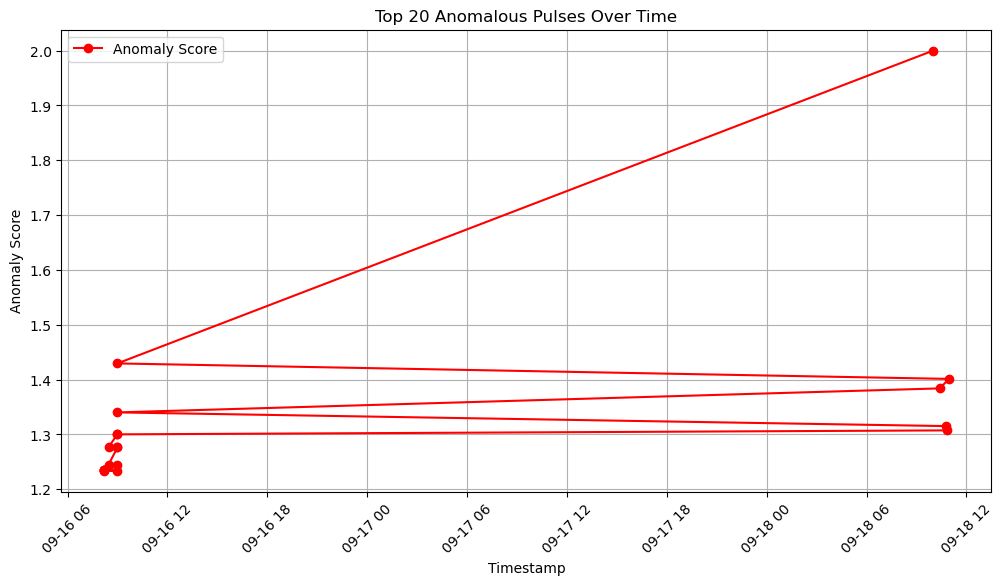

In [51]:
# Time-series plot
plt.figure(figsize=(12, 6))
plt.plot(top_anomalies["timestamps"], top_anomalies["Anomaly_Score"], marker='o', linestyle='-', color='r', label="Anomaly Score")
plt.xlabel("Timestamp")
plt.ylabel("Anomaly Score")
plt.title("Top 20 Anomalous Pulses Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

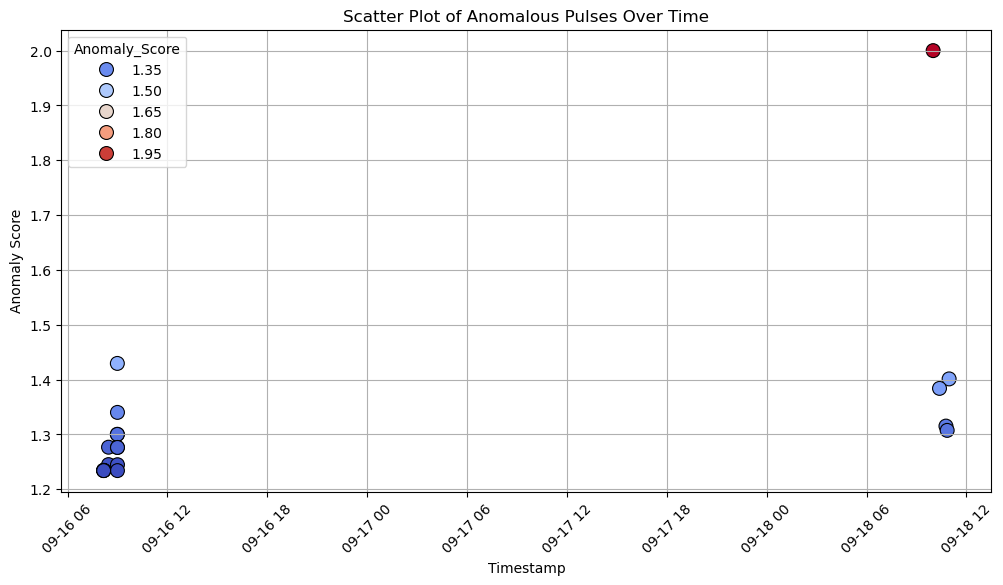

In [52]:
# Scatter Plot: Anomaly Score vs. Timestamp
plt.figure(figsize=(12, 6))
sns.scatterplot(x=top_anomalies["timestamps"], y=top_anomalies["Anomaly_Score"], hue=top_anomalies["Anomaly_Score"], palette="coolwarm", s=100, edgecolor="k")
plt.xlabel("Timestamp")
plt.ylabel("Anomaly Score")
plt.title("Scatter Plot of Anomalous Pulses Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

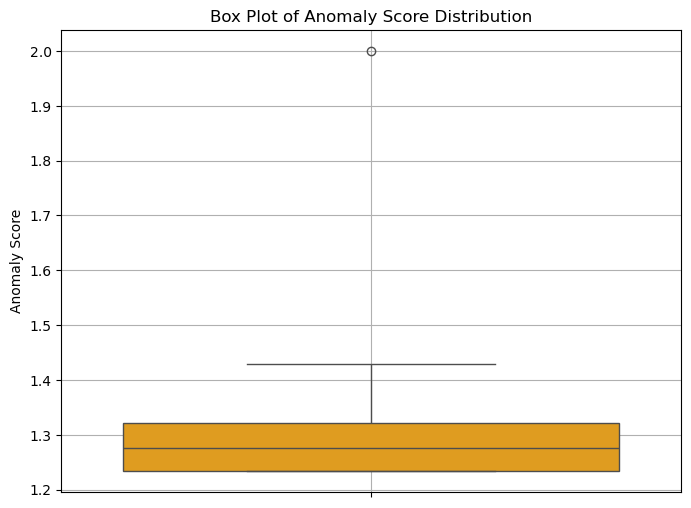

In [53]:
# Box Plot: Anomaly Score Distribution
plt.figure(figsize=(8, 6))
sns.boxplot(y=top_anomalies["Anomaly_Score"], color="orange")
plt.ylabel("Anomaly Score")
plt.title("Box Plot of Anomaly Score Distribution")
plt.grid(True)
plt.show()

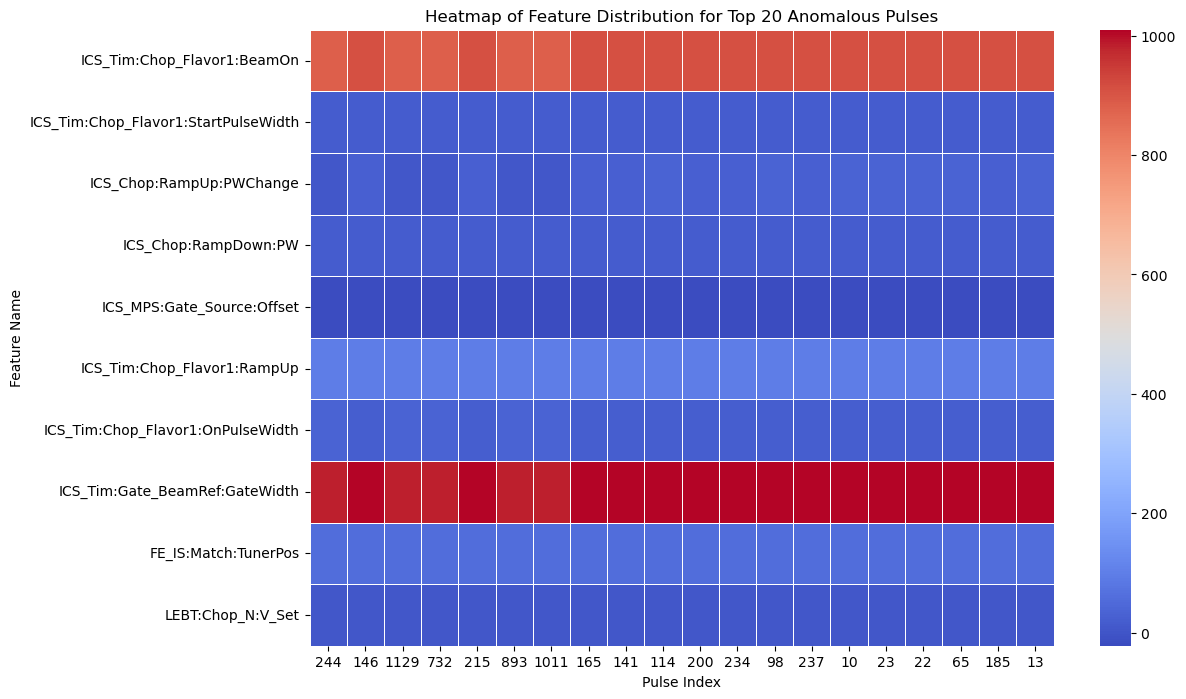

In [54]:
# Heatmap: Feature Distribution for Top Anomalies
plt.figure(figsize=(12, 8))
sns.heatmap(top_anomalies.iloc[:, :10].T, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Heatmap of Feature Distribution for Top 20 Anomalous Pulses")
plt.xlabel("Pulse Index")
plt.ylabel("Feature Name")
plt.show()

In [55]:
top_anomalies

,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,ICS_Tim:Chop_Flavor1:OnPulseWidth,ICS_Tim:Gate_BeamRef:GateWidth,FE_IS:Match:TunerPos,LEBT:Chop_N:V_Set,...,Trace_Std,Trace_Peak,Trace_FFT,timestamp_seconds,time_diff,DBSCAN_Label,KMeans_Anomaly_Score,Isolation_Forest_Score,OneClassSVM_Score,Anomaly_Score
244,884.0,18.0,6.0,18.0,-21.666666,98.0,32.0,984.0,58.029999,2.7,...,0.019429,0.054346,52.504780,1.450496e+06,176410.550709,-1,5.522216,-1,-1,2.000000
146,910.0,18.0,24.0,18.0,-22.000000,98.0,21.0,1010.0,58.029999,2.7,...,0.016840,0.056494,31.605632,1.274058e+06,0.099997,0,2.370990,-1,-1,1.429355
1129,884.0,18.0,6.0,18.0,-21.666666,98.0,33.0,984.0,58.029999,2.7,...,0.020282,0.057275,60.240980,1.453953e+06,118.295463,1,2.215011,-1,-1,1.401109
732,884.0,18.0,6.0,18.0,-21.666666,98.0,32.0,984.0,58.029999,2.7,...,0.019695,0.057275,53.128491,1.451873e+06,0.016666,1,2.119468,-1,-1,1.383807
215,910.0,18.0,24.0,18.0,-22.000000,98.0,21.0,1010.0,58.029999,2.7,...,0.016782,0.055957,31.630999,1.274083e+06,0.099996,0,1.877608,-1,-1,1.340010
893,884.0,18.0,6.0,18.0,-21.666666,98.0,33.0,984.0,58.029999,2.7,...,0.020267,0.056738,60.092334,1.453266e+06,363.802714,1,1.739623,-1,-1,1.315023
1011,884.0,18.0,6.0,18.0,-21.666666,98.0,33.0,984.0,58.029999,2.7,...,0.020131,0.056738,59.575128,1.453531e+06,174.476641,1,1.696428,-1,-1,1.307201
165,910.0,18.0,24.0,18.0,-22.000000,98.0,21.0,1010.0,58.029999,2.7,...,0.016797,0.055713,31.497119,1.274060e+06,0.099996,0,1.656362,-1,-1,1.299945
141,910.0,18.0,24.0,18.0,-22.000000,98.0,21.0,1010.0,58.029999,2.7,...,0.016783,0.055713,31.528175,1.274057e+06,0.099996,0,1.656144,-1,-1,1.299906
114,910.0,18.0,32.0,18.0,-22.000000,98.0,20.0,1010.0,58.029999,2.7,...,0.016834,0.055566,31.650838,1.272152e+06,0.099996,0,1.526929,-1,-1,1.276507


In [62]:
df_combined_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   ICS_Tim:Chop_Flavor1:BeamOn           1188 non-null   float32       
 1   ICS_Tim:Chop_Flavor1:StartPulseWidth  1188 non-null   float32       
 2   ICS_Chop:RampUp:PWChange              1188 non-null   float32       
 3   ICS_Chop:RampDown:PW                  1188 non-null   float32       
 4   ICS_MPS:Gate_Source:Offset            1188 non-null   float32       
 5   ICS_Tim:Chop_Flavor1:RampUp           1188 non-null   float32       
 6   ICS_Tim:Chop_Flavor1:OnPulseWidth     1188 non-null   float32       
 7   ICS_Tim:Gate_BeamRef:GateWidth        1188 non-null   float32       
 8   FE_IS:Match:TunerPos                  1188 non-null   float32       
 9   LEBT:Chop_N:V_Set                     1188 non-null   float32       
 10  

In [64]:
from sklearn.ensemble import IsolationForest

window_size = 5  # Use last (N-1) pulses to predict the Nth pulse

rolling_features = []
rolling_targets = []

for i in range(window_size, len(df_combined_features)):
    past_pulses = df_combined_features.iloc[i - window_size:i].drop(columns=["timestamps"])
    current_pulse = df_combined_features.iloc[i].drop(columns=["timestamps"])

    # Flatten past pulses into a single row
    rolling_features.append(past_pulses.values.flatten())
    rolling_targets.append(current_pulse.values.flatten())

# Convert to NumPy arrays
X_train = np.array(rolling_features)
y_test = np.array(rolling_targets)  # Nth pulse features to evaluate


iso_forest_seq = IsolationForest(contamination=0.05, random_state=42)
iso_forest_seq.fit(X_train)


IsolationForest(contamination=0.05, random_state=42)

In [71]:
# Compute anomaly scores for the Nth pulse

numeric_cols = df_combined_features.select_dtypes(include=[np.number]).columns 
y_test = df_combined_features.iloc[window_size:][numeric_cols]  

y_test_flattened = np.tile(y_test.values, (1, window_size)).reshape(y_test.shape[0], -1)


nth_anomaly_scores = iso_forest_seq.decision_function(y_test_flattened)  
nth_anomaly_labels = iso_forest_seq.predict(y_test_flattened) 

# Store results
df_nth_anomalies = df_combined_features.iloc[window_size:].copy()
df_nth_anomalies["Nth_Anomaly_Score"] = nth_anomaly_scores
df_nth_anomalies["Nth_Anomaly_Label"] = nth_anomaly_labels

# Rank by anomaly score
df_nth_anomalies_sorted = df_nth_anomalies.sort_values(by="Nth_Anomaly_Score")
df_nth_anomalies_sorted

,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,ICS_Tim:Chop_Flavor1:OnPulseWidth,ICS_Tim:Gate_BeamRef:GateWidth,FE_IS:Match:TunerPos,LEBT:Chop_N:V_Set,...,Trace_FFT,timestamp_seconds,time_diff,DBSCAN_Label,KMeans_Anomaly_Score,Isolation_Forest_Score,OneClassSVM_Score,Anomaly_Score,Nth_Anomaly_Score,Nth_Anomaly_Label
7,904.0,18.0,3.0,18.0,-12.000000,98.0,18.0,1004.0,58.029999,2.7,...,63.408026,1.868163e+05,183738.252995,-1,0.000000,-1,-1,1.000000,-0.244863,-1
5,908.0,18.0,3.0,18.0,-24.000000,98.0,42.0,1008.0,58.029999,2.7,...,62.585801,2.675897e+03,722.405627,-1,0.854994,-1,-1,1.154828,-0.230890,-1
6,908.0,18.0,3.0,18.0,-24.000000,98.0,42.0,1008.0,58.029999,2.7,...,61.696572,3.078049e+03,402.151243,-1,0.127928,-1,-1,1.023166,-0.223424,-1
244,884.0,18.0,6.0,18.0,-21.666666,98.0,32.0,984.0,58.029999,2.7,...,52.504780,1.450496e+06,176410.550709,-1,5.522216,-1,-1,2.000000,-0.174961,-1
893,884.0,18.0,6.0,18.0,-21.666666,98.0,33.0,984.0,58.029999,2.7,...,60.092334,1.453266e+06,363.802714,1,1.739623,-1,-1,1.315023,-0.128901,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,884.0,18.0,6.0,18.0,-21.666666,98.0,32.0,984.0,58.029999,2.7,...,52.830780,1.451030e+06,0.016666,1,0.667542,1,1,0.120883,0.207853,1
476,884.0,18.0,6.0,18.0,-21.666666,98.0,32.0,984.0,58.029999,2.7,...,52.587775,1.451037e+06,0.016666,1,0.594923,1,1,0.107733,0.207869,1
490,884.0,18.0,6.0,18.0,-21.666666,98.0,32.0,984.0,58.029999,2.7,...,52.742179,1.451067e+06,0.016666,1,0.669528,1,1,0.121243,0.208082,1
567,884.0,18.0,6.0,18.0,-21.666666,98.0,32.0,984.0,58.029999,2.7,...,52.580454,1.451132e+06,0.016666,1,0.679609,1,1,0.123068,0.208698,1


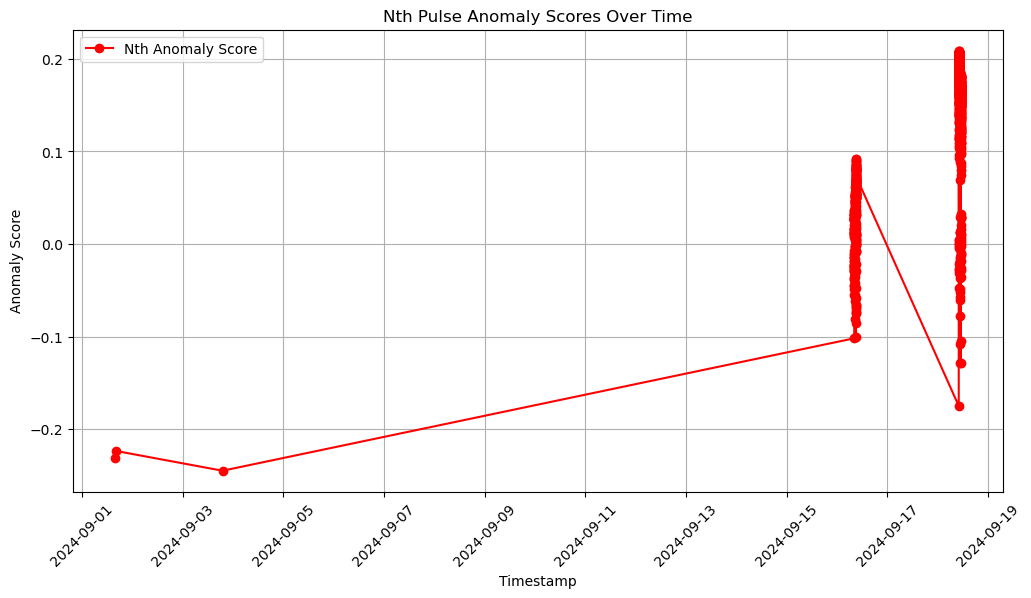

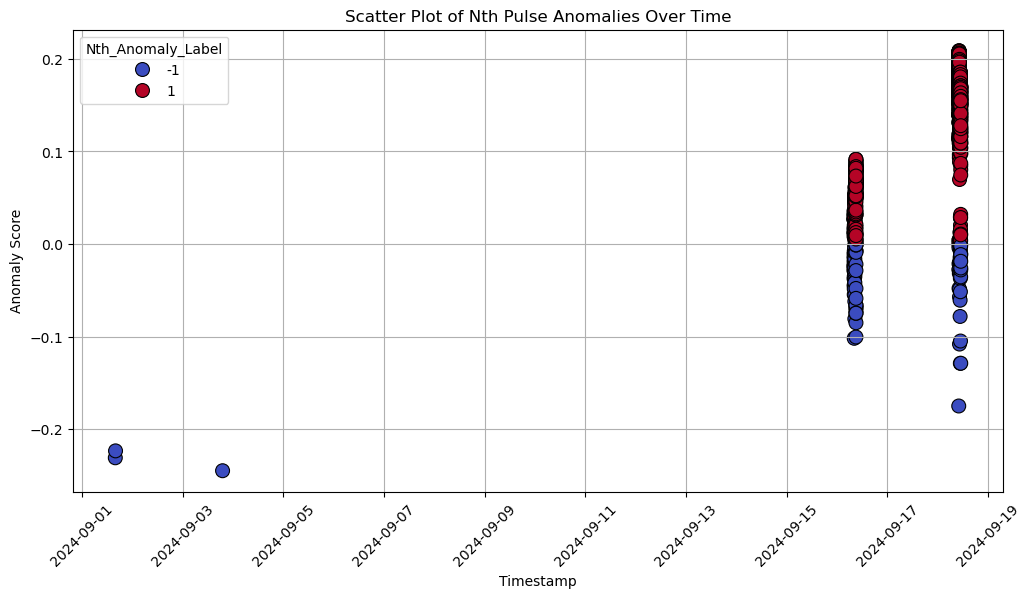

In [72]:
# Time-series plot of Nth pulse anomaly scores
plt.figure(figsize=(12, 6))
plt.plot(df_nth_anomalies["timestamps"], df_nth_anomalies["Nth_Anomaly_Score"], marker='o', linestyle='-', color='r', label="Nth Anomaly Score")
plt.xlabel("Timestamp")
plt.ylabel("Anomaly Score")
plt.title("Nth Pulse Anomaly Scores Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

# Scatter Plot: Nth Pulse Anomaly Scores vs. Time
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df_nth_anomalies["timestamps"], y=df_nth_anomalies["Nth_Anomaly_Score"], hue=df_nth_anomalies["Nth_Anomaly_Label"], palette="coolwarm", s=100, edgecolor="k")
plt.xlabel("Timestamp")
plt.ylabel("Anomaly Score")
plt.title("Scatter Plot of Nth Pulse Anomalies Over Time")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [73]:
df_nth_anomalies_sorted.head()

,ICS_Tim:Chop_Flavor1:BeamOn,ICS_Tim:Chop_Flavor1:StartPulseWidth,ICS_Chop:RampUp:PWChange,ICS_Chop:RampDown:PW,ICS_MPS:Gate_Source:Offset,ICS_Tim:Chop_Flavor1:RampUp,ICS_Tim:Chop_Flavor1:OnPulseWidth,ICS_Tim:Gate_BeamRef:GateWidth,FE_IS:Match:TunerPos,LEBT:Chop_N:V_Set,...,Trace_FFT,timestamp_seconds,time_diff,DBSCAN_Label,KMeans_Anomaly_Score,Isolation_Forest_Score,OneClassSVM_Score,Anomaly_Score,Nth_Anomaly_Score,Nth_Anomaly_Label
7,904.0,18.0,3.0,18.0,-12.000000,98.0,18.0,1004.0,58.029999,2.7,...,63.408026,1.868163e+05,183738.252995,-1,0.000000,-1,-1,1.000000,-0.244863,-1
5,908.0,18.0,3.0,18.0,-24.000000,98.0,42.0,1008.0,58.029999,2.7,...,62.585801,2.675897e+03,722.405627,-1,0.854994,-1,-1,1.154828,-0.230890,-1
6,908.0,18.0,3.0,18.0,-24.000000,98.0,42.0,1008.0,58.029999,2.7,...,61.696572,3.078049e+03,402.151243,-1,0.127928,-1,-1,1.023166,-0.223424,-1
244,884.0,18.0,6.0,18.0,-21.666666,98.0,32.0,984.0,58.029999,2.7,...,52.504780,1.450496e+06,176410.550709,-1,5.522216,-1,-1,2.000000,-0.174961,-1
893,884.0,18.0,6.0,18.0,-21.666666,98.0,33.0,984.0,58.029999,2.7,...,60.092334,1.453266e+06,363.802714,1,1.739623,-1,-1,1.315023,-0.128901,-1
